Get data

In [1578]:
file_path = "./data/X.csv"
X = pd.read_csv(file_path)

file_path = "./data/y.csv"
y = pd.read_csv(file_path)


In [1579]:
# df_org['Education Level'].unique()

array(["bachelor's|degr", 'bachelor', "master's|degr", 'p', 'master',
       'high|scho', nan], dtype=object)

In [1541]:
# replacing redundant eduction level values
# df_education = df_org['Education Level'].replace(to_replace = "bachelor's|degr", value = 'bachelor').replace(to_replace = "master's|degr", value = 'master')

In [1542]:
# df_edu_correct = pd.DataFrame({'Education_Level_corrected': df_education})
# df_edu_correct['Education_Level_corrected'].unique()

array(['bachelor', 'master', 'p', 'high|scho', nan], dtype=object)

In [1543]:
# df_org2 = df_org.join(df_edu_correct)
# df_org2.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'Education Level'], inplace = True)

In [1581]:
# removing irrational 'Years of Experience' values, e.g. 120...
df_org2['Years of Experience'].sort_values().unique()
df_org2 = df_org2[df_org2['Years of Experience'] != 120.0]
df_org2['Years of Experience'].sort_values()

# Removing 'Years of Experience' NaN values
# df_org2 = df_org2.drop(labels = [172, 260, 5247], axis = 0)
df_org2['Years of Experience'].sort_values()

id
2831     1.0
5632     1.0
5031     1.0
5715     1.0
5777     1.0
        ... 
2846    34.0
2871    34.0
2501    35.0
2435    35.0
2421    36.0
Name: Years of Experience, Length: 5346, dtype: float64

In [1582]:
# removing 'O' values from Gender
df_org2 = df_org2[df_org2['Gender'] != 'O']
# df_org2['Gender'].unique()

# # removing sparse salary points
# df_org2 = df_org2[df_org2['Salary'] <210000]
# df_org2 = df_org2[df_org2['Salary'] >10000]

# # removing sparse professionalism points
# df_org2 = df_org2[df_org2['professionalism'] < 1000]

array(['M', 'F'], dtype=object)

In [1584]:
# df_org = X.join(y.set_index('id'))

df_mod = df_org2

# df_mod.set_index('id',inplace= True)

# clear all null lines
for column in df_mod.columns:
    nulls_mask = df_mod[column].notnull()  # or column_with_nulls.isna()
    df_mod = df_mod[nulls_mask]

# drop unnamed columns
# df_mod.drop(columns='Unnamed: 0', inplace=True)
# df_mod.drop(columns='Unnamed: 0.1',inplace=True)

# removing data point with Gender = 'O'
# df_mod = df_mod[df_mod['Gender']!='O']

# setting 'id' column as index
# df_mod.set_index('id', inplace = True)

# deal with categorial columns

label_encoder = LabelEncoder()
for column in df_mod.select_dtypes(include=['object']).columns:
    df_mod[column + '_encoded'] = label_encoder.fit_transform(df_mod[column])
    
df_mod2 = df_mod[['Age','Years of Experience','professionalism','Salary', 'Gender_encoded', 'Job Title_encoded',
       'Country_encoded', 'Race_encoded', 'Education_Level_corrected_encoded']]

# Train test split
X_train, X_test, y_train, y_test =train_test_split(df_mod2.drop(columns = ['Salary','Age','Years of Experience']), df_mod2.Salary, test_size = 0.3, random_state = 42)

# get all relevant column names
categorical_columns = df_mod.select_dtypes(include=['object']).columns.tolist()

# drop_categorial = True
# if (drop_categorial):
#     df_mod = df_mod.drop(columns=categorical_columns)
# else:
#     # drop some of them
#     categorical_columns_remove = 'Job Title'
#     categorical_columns = [item for item in categorical_columns if item != categorical_columns_remove]


#     df_mod = pd.get_dummies(df_mod,columns = categorical_columns)

# df = df_mod

In [1548]:
df_mod2.describe()

,Age,Years of Experience,professionalism,Salary,Gender_encoded,Job Title_encoded,Country_encoded,Race_encoded,Education_Level_corrected_encoded
count,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000
mean,35.189392,9.640929,317.380662,118857.186107,0.551748,83.521239,2.001408,4.903544,1.237268
std,7.634432,6.069320,304.883385,52022.069232,0.497373,50.357635,1.415706,3.386086,1.220052
min,22.000000,1.000000,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,5.000000,84.000000,75000.000000,0.000000,38.000000,1.000000,1.000000,0.000000
50%,33.000000,8.000000,217.000000,120000.000000,1.000000,87.000000,2.000000,5.000000,1.000000
75%,40.000000,13.000000,451.000000,162000.000000,1.000000,139.000000,3.000000,9.000000,2.000000
max,64.000000,36.000000,2040.000000,250000.000000,1.000000,164.000000,4.000000,9.000000,3.000000


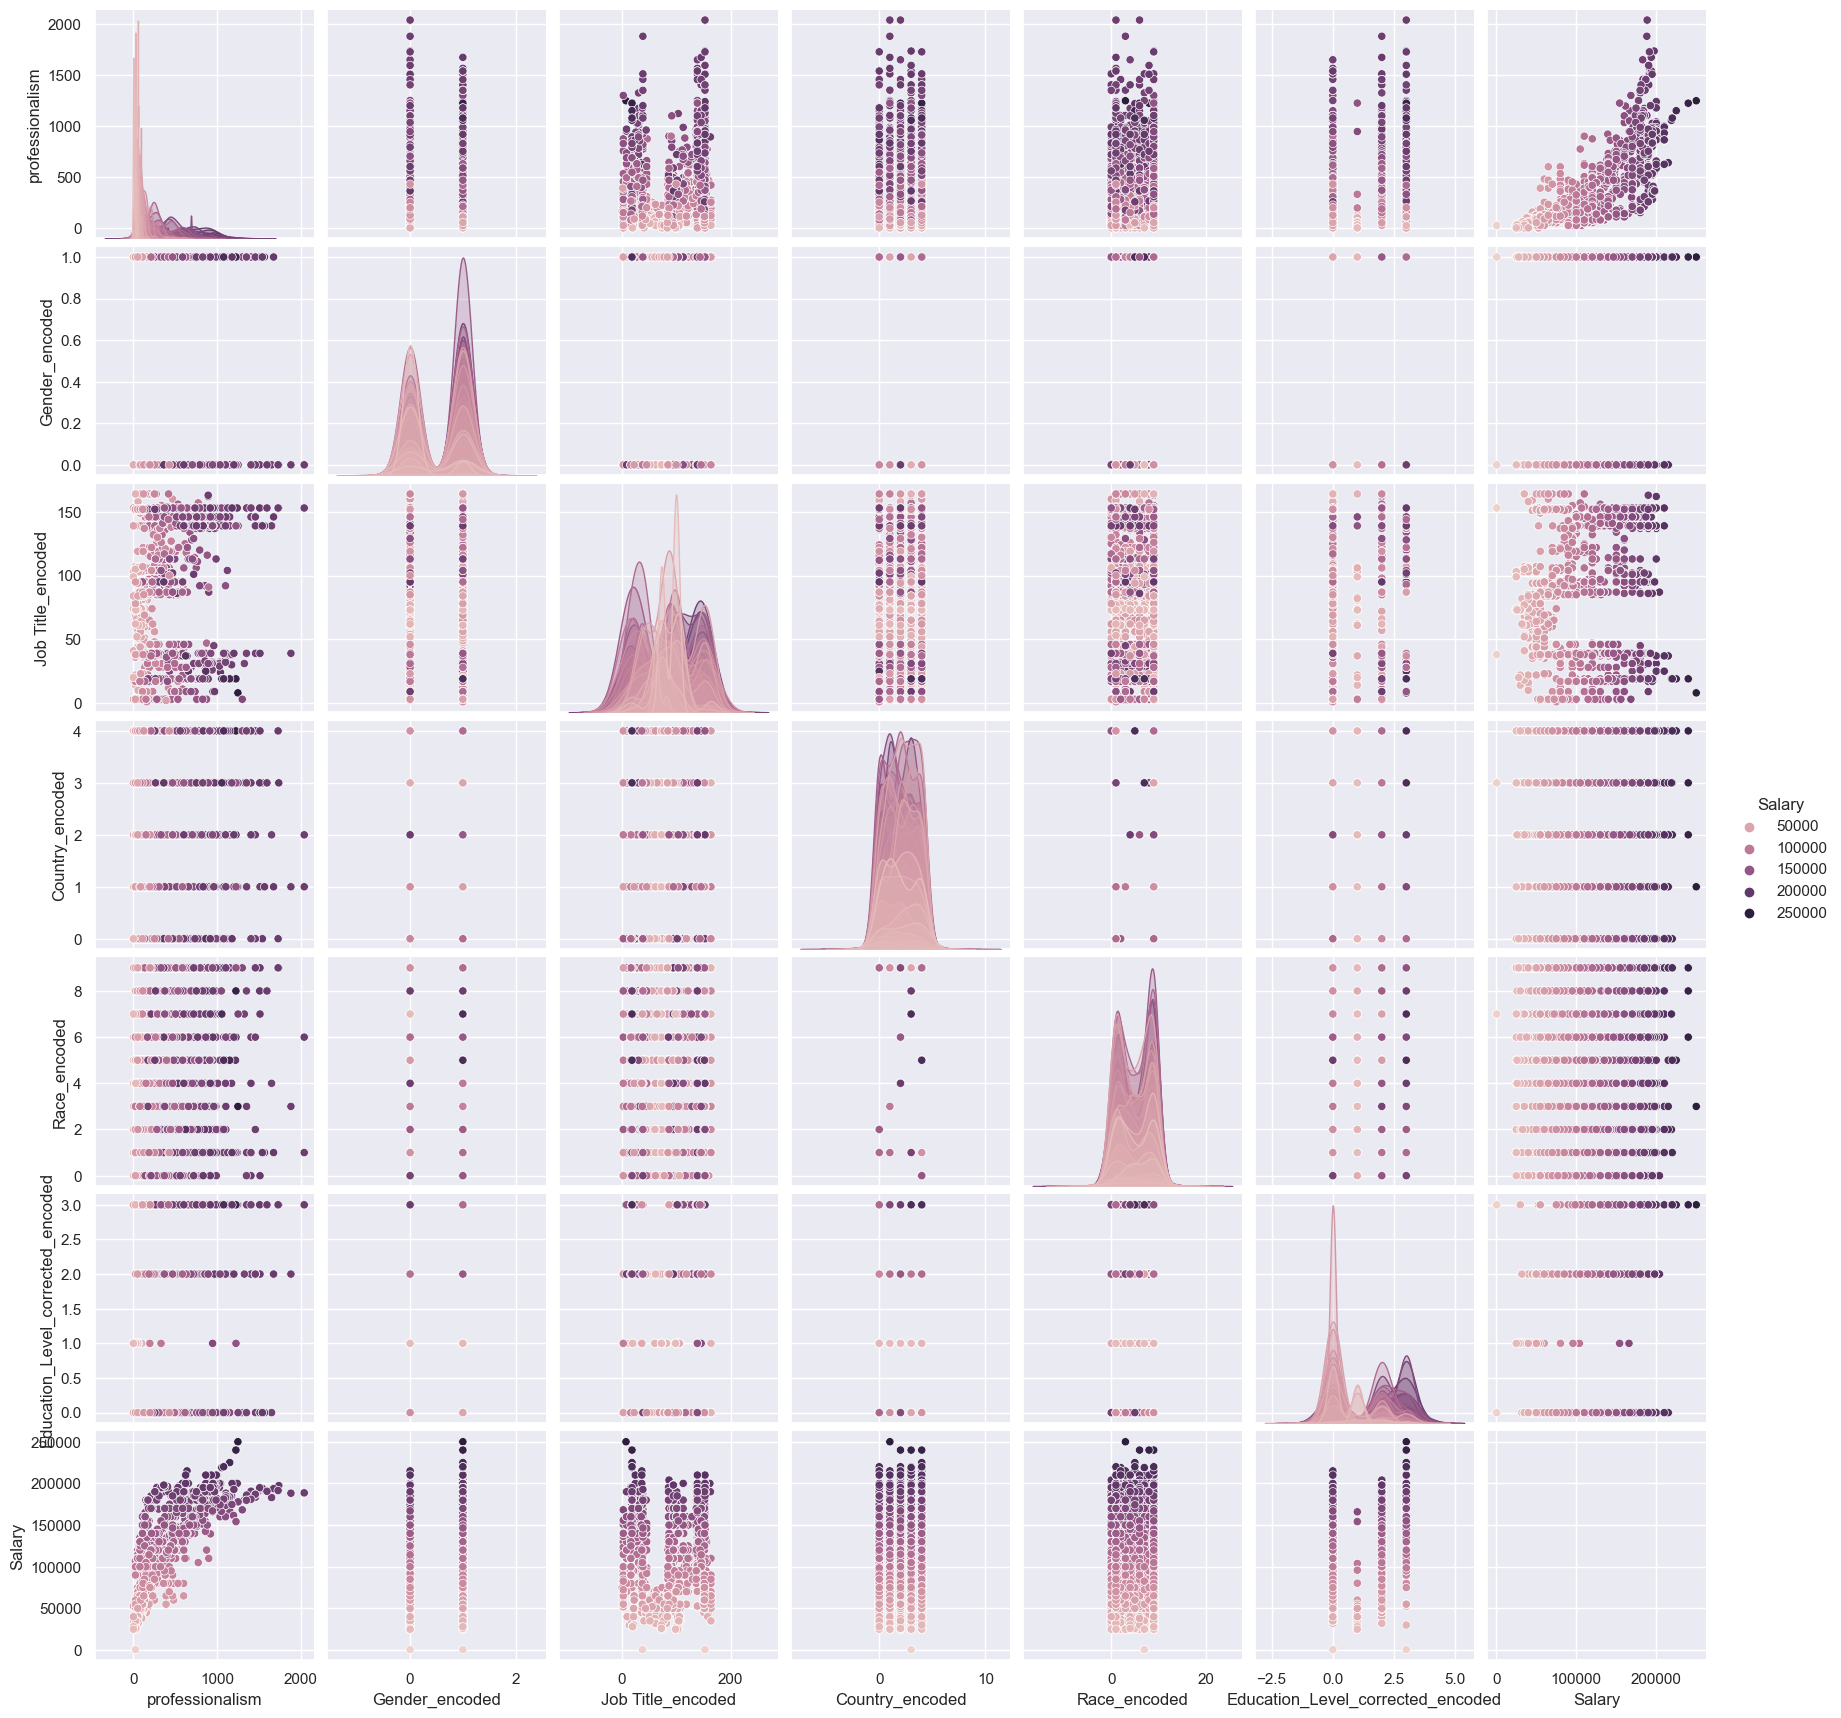

In [1571]:
sns.pairplot(X_train.join(y.set_index('id')), vars = X_train.join(y.set_index('id')).columns, hue = 'Salary')

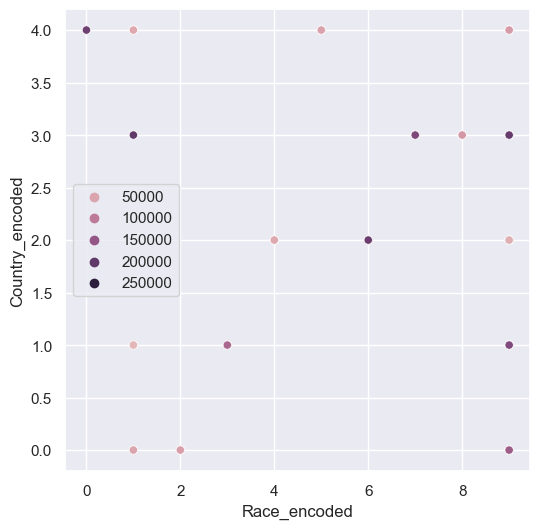

In [1550]:
sns.scatterplot(data = X_train.join(y_train),x= 'Race_encoded', y = 'Country_encoded', hue = 'Salary')
plt.legend(loc = 'best')

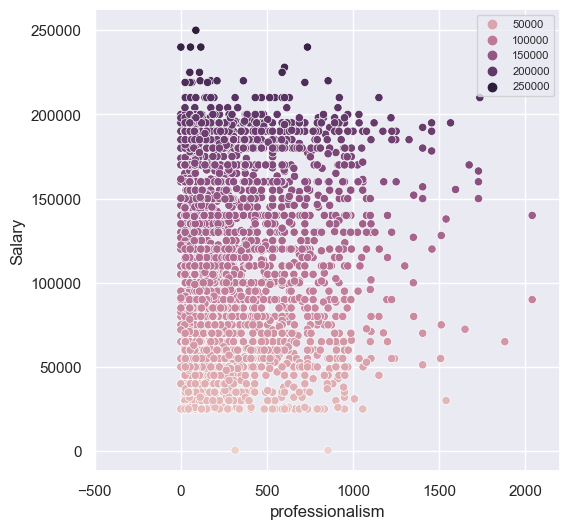

In [1551]:
# fig, ax = plt.subplots()
# sns.distplot(data, ax=ax)
# ax.set_xlim(1, 70)
# plt.show()

fig, ax = plt.subplots()
sns.scatterplot(data = X_train.join(y_train),x= 'professionalism', y = 'Salary', hue = 'Salary')
ax.set_xlim(-500, 2200)
plt.legend(loc = 'best', prop={'size':8})
plt.show()

In [736]:
races = X_train['Race_encoded'].unique()
countries = X_train['Country_encoded'].unique()

# sns.pairplot(X_train_copy.join(y), vars = X_train_copy.join(y).columns, hue = 'Salary')

In [737]:
groups.unique().size

17

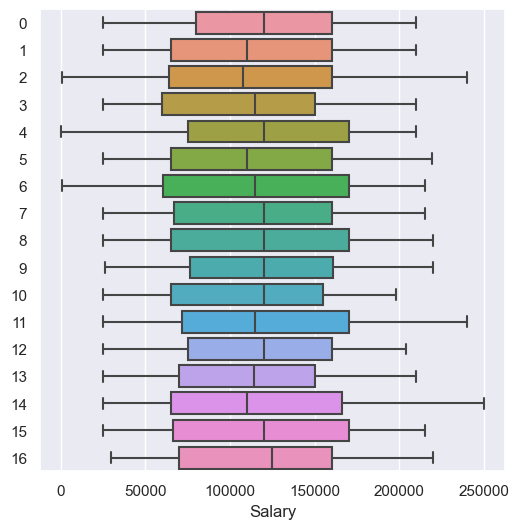

In [1552]:
# removing 'Salary' NaN values
# data = data[~data['Salary'].isna()]
# grouping by race and country
groups = data.groupby(['Country_encoded', 'Race_encoded']).ngroup()
# groups = X_train.groupby(['Education_Level_corrected_encoded']).ngroup()

sns.boxplot(data = X_train.join(y), x = 'Salary', y = groups, orient = 'h')
# setting sns figure size
sns.set(rc={'figure.figsize':(6,6)})

In [1212]:
groups.nunique()

17

In [1553]:
# The following code performs a Kolmogorov-Smirnov test on these two datasets 
# to determine if they came from the same distribution

from scipy.stats import ks_2samp

#perform Kolmogorov-Smirnov test

ks_2samp(groups[groups == 12], groups[groups == 15])[1]

# i, j = 0,0
# res = []

# pair-wise distribution, KS test:
# for i in range(len(groups.unique())):
#     for j in range(len(groups.unique())):
#         # print(f"i = {i}, j = {j}")
#         # print(ks_2samp(groups[groups == i], groups[groups == j])[1],'\n')
#         res.append(ks_2samp(groups[groups == i], groups[groups == j])[1])

# printing the KS test p-value, to assess whetehr most distribs are statistically different. Answer = Yes.
# print(res.sort())

1.1151471543020886e-95

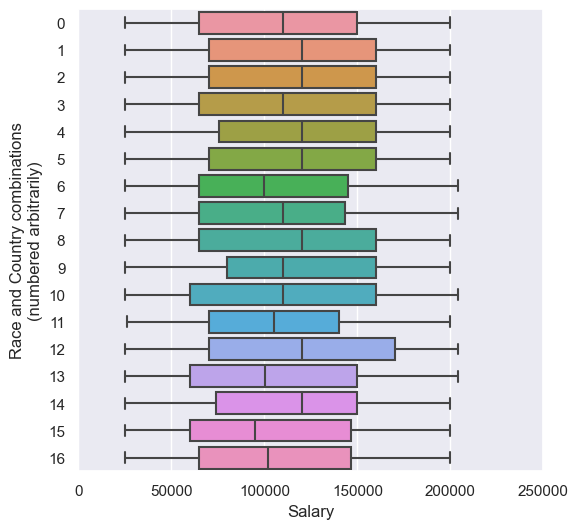

In [740]:
# # Filtering out sparse data

# data2 = data.loc[(data['professionalism'] < 1001) & (data['Salary'] < 210000) & (data['Salary'] > 10000)] 

# # repeating the groupby CountryxRace boxplot analysis:

# groups2 = data2.groupby(['Country_encoded', 'Race_encoded']).ngroup()

# sns.boxplot(data = data2, x = 'Salary', y = groups2, orient = 'h').set(ylabel = "Race and Country combinations\n(numbered arbitrarily)", xlim = (0,250000))
# # setting sns figure size
# sns.set(rc={'figure.figsize':(6,6)})

# # Data Cleaning decreases intra-group variance and stress inter-groups distrib. differences

In [755]:
# from sklearn.metrics import mean_squared_error as mse

# def my_fit(X,y):
#   X=X.join(y)
#   model2 = X.groupby('group_number')[y.name].mean()
#   return model2

# def my_predict(X,model2):
#   y_pred2 = X.group_number.map(model2)
#   return y_pred2

# def rmsle(y_true: pd.Series, y_pred:pd.Series):
#     return (((np.log1p(y_true)-np.log1p(y_pred))**2).mean())**0.5

In [1585]:
df_mod2.describe()
# features for rounding: height, weight

,Age,Years of Experience,professionalism,Salary,Gender_encoded,Job Title_encoded,Country_encoded,Race_encoded,Education_Level_corrected_encoded
count,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000
mean,35.189392,9.640929,317.380662,118857.186107,0.551748,83.521239,2.001408,4.903544,1.237268
std,7.634432,6.069320,304.883385,52022.069232,0.497373,50.357635,1.415706,3.386086,1.220052
min,22.000000,1.000000,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,5.000000,84.000000,75000.000000,0.000000,38.000000,1.000000,1.000000,0.000000
50%,33.000000,8.000000,217.000000,120000.000000,1.000000,87.000000,2.000000,5.000000,1.000000
75%,40.000000,13.000000,451.000000,162000.000000,1.000000,139.000000,3.000000,9.000000,2.000000
max,64.000000,36.000000,2040.000000,250000.000000,1.000000,164.000000,4.000000,9.000000,3.000000


In [1789]:
# add rounding step in the fit & predict methods 

#   x = copy.deepcopy(X[:])
#   x.carat =  round(x.carat/a )*a

#   x.col = x.carat.astype(str) + "_" +  x.cut.astype(str)+ "_" +  x.clarity.astype(str) + "_" +  x.color.astype(str)

#   model = y.groupby([x.col]).mean()

#   return model

from sklearn.metrics import mean_squared_error as mse
import copy

def my_fit_transform(X,y, columns = df_mod2.columns[:5].to_list() , bin_sizes_lst = [5,5,100,0.1,5]):
  X=X.join(y)
# Copying X and creating a 'new_col' column
  X_copy = copy.deepcopy(X[:])
  X_copy.insert(loc = 0, column = 'new_col', value = str())

# rounding numeric features to create desired bins 
  for column,bin_size in zip(columns,bin_sizes_lst):
    X_copy[column + '_bin'] = round(X_copy[column]/bin_size)*bin_size
    X_copy['new_col'] = X_copy ['new_col'].astype(str) + X_copy[column + '_bin'].astype(str) + '_'

# grouping by 'new_col' to extract mean(y) 
  model = X_copy.groupby('new_col')[y.name].mean().round(1)
  return model, X_copy

def my_predict(X,model,columns = df_mod2.columns[:5].to_list() , bin_sizes_lst = [5,5,100,0.1,5]):
  
  X_copy = copy.deepcopy(X[:])
  X_copy.insert(loc = 0, column = 'new_col', value = str())

  for column,bin_size in zip(columns,bin_sizes_lst):
    if column == 'height':
        X_copy[column + '_bin'] = round(X_copy[column]/bin_size)*bin_size
        X_copy['new_col'] = X_copy ['new_col'].astype(str) + X_copy[column + '_bin'].astype(str) + '_'
    else:
        X_copy[column + '_bin'] = round(X_copy[column]/bin_size)*bin_size
        X_copy['new_col'] = X_copy ['new_col'].astype(str) + X_copy[column + '_bin'].astype(str) + '_'
  
  y_pred = X_copy['new_col'].map(model)
  return y_pred

def rmsle(y_true: pd.Series, y_pred:pd.Series):
    return (((np.log1p(y_true)-np.log1p(y_pred))**2).mean())**0.5

In [1700]:
df_mod2.columns

Index(['Age', 'Years of Experience', 'professionalism', 'height', 'weight',
       'Gender_encoded', 'Job Title_encoded', 'Country_encoded',
       'Race_encoded', 'Education_Level_corrected_encoded', 'Salary'],
      dtype='object')

In [1798]:
# converting data types and or data structure to better match the need 
df_mod2.Age = df_mod2.Age.astype(int)
df_mod2['Years of Experience']  = df_mod2['Years of Experience'].astype(int)
df_mod2['professionalism']  = df_mod2['professionalism'].astype(int)
df_mod2['height'] = df_mod2['height'].round(2)
df_mod2['weight'] = df_mod2['weight'].astype(int)
df_mod2['Salary'] = df_mod2['Salary'].astype(int)
df_mod2.head()

,Age,Years of Experience,professionalism,height,weight,Gender_encoded,Job Title_encoded,Country_encoded,Race_encoded,Education_Level_corrected_encoded,Salary
id,,,,,,,,,,,
2477,52,24,1150,1.8,95,1,3,0,1,0,90000
76,52,23,1100,2.4,87,0,92,4,9,0,65000
242,39,11,380,1.8,72,0,136,2,6,0,200000
5544,34,11,297,2.1,77,0,87,4,9,2,55000
6017,34,9,256,2.1,54,0,87,3,9,0,120000


In [1795]:
X_copy = pd.DataFrame({})

# # split the datasets to train and test
X_train, X_test, y_train, y_test = train_test_split(df_mod2[['Age', 'Years of Experience', 'professionalism', 'height', 'weight']],df_mod2.Salary, test_size=0.33, random_state=42)


model, X_copy = my_fit_transform(X_train, y_train)

# binned_columns = X_copy.columns[X_copy.columns.size - X_train.columns.size:X_copy.columns.size].values.tolist()
# binned_columns

y_pred = my_predict(X_test,model)

y_pred[~y_pred.isnull()]

id
1793    130000.0
602     111666.7
4596     75000.0
5896    150200.0
2414    180000.0
          ...   
4064    100000.0
1687     92000.0
1858    115000.0
2298    135086.0
5100     99000.0
Name: new_col, Length: 940, dtype: float64

In [1797]:
df_mod2.head()

,Age,Years of Experience,professionalism,height,weight,Gender_encoded,Job Title_encoded,Country_encoded,Race_encoded,Education_Level_corrected_encoded,Salary
id,,,,,,,,,,,
2477,52,24,1150,1.8,95,1,3,0,1,0,90000
76,52,23,1100,2.4,87,0,92,4,9,0,65000
242,39,11,380,1.8,72,0,136,2,6,0,200000
5544,34,11,297,2.1,77,0,87,4,9,2,55000
6017,34,9,256,2.1,54,0,87,3,9,0,120000


In [1668]:
df_mod2.columns[:5].to_list()

['Age', 'Years of Experience', 'professionalism', 'height', 'weight']

In [1591]:
df_mod2 = df_mod2.join(df_org[['height', 'weight']])
df_mod2.columns

Index(['Age', 'Years of Experience', 'professionalism', 'Salary',
       'Gender_encoded', 'Job Title_encoded', 'Country_encoded',
       'Race_encoded', 'Education_Level_corrected_encoded', 'height',
       'weight'],
      dtype='object')

In [1609]:
import copy
# Setting the desired df columns order
df_mod2 = df_mod2[['Age', 'Years of Experience', 'professionalism','height',
       'weight','Gender_encoded', 'Job Title_encoded', 'Country_encoded',
       'Race_encoded', 'Education_Level_corrected_encoded','Salary']]

# binning the non-object/numeric features
df_mod2.columns[:5]
bin_sizes = [5,5,100,0.1,5]

df_copy = copy.deepcopy(df_mod2[:])

for column,bin_size in zip(df_mod2.columns[:5],bin_sizes):
    # print(column)
    # print(bin_size)
    df_copy[column + '_bin'] = round(df_copy[column]/bin_size)*bin_size

In [1614]:
dfc = df_copy[['Age_bin', 'Years of Experience_bin', 'professionalism_bin',
       'height_bin', 'weight_bin','Gender_encoded', 'Job Title_encoded', 'Country_encoded',
       'Race_encoded', 'Education_Level_corrected_encoded','Salary']]

dfc.describe()

,Age_bin,Years of Experience_bin,professionalism_bin,height_bin,weight_bin,Gender_encoded,Job Title_encoded,Country_encoded,Race_encoded,Education_Level_corrected_encoded,Salary
count,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000,4261.000000
mean,35.177188,9.728937,320.136118,2.005773,66.906829,0.551748,83.521239,2.001408,4.903544,1.237268,118857.186107
std,7.726110,6.185928,305.640373,0.296370,18.353800,0.497373,50.357635,1.415706,3.386086,1.220052,52022.069232
min,20.000000,0.000000,0.000000,1.500000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500.000000
25%,30.000000,5.000000,100.000000,1.800000,55.000000,0.000000,38.000000,1.000000,1.000000,0.000000,75000.000000
50%,35.000000,10.000000,200.000000,2.000000,65.000000,1.000000,87.000000,2.000000,5.000000,1.000000,120000.000000
75%,40.000000,15.000000,500.000000,2.300000,80.000000,1.000000,139.000000,3.000000,9.000000,2.000000,162000.000000
max,65.000000,35.000000,2000.000000,2.500000,140.000000,1.000000,164.000000,4.000000,9.000000,3.000000,250000.000000


In [1558]:
# # custom groupby-based step-wise model, using CLEAN data (dfc)

# # X2 = data2.drop(columns = 'Salary')
# # y2 = data2.Salary

# from sklearn.metrics import mean_squared_error as mse

# for i in range(1,len(X_train.columns.values)+1):
    
#   # itterate over tested feature combinations
#   features = list(X_train.columns[:i].values)
#   # features = ['Country_encoded', 'Race_encoded']

#   # create an X Series grouped by chosen features; each unique feature combination is group-numbered
#   X_train['group_number'] = X_train.groupby(features).ngroup()
 

#   # split the datasets to train and test
#   # X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

#   # create a model per selected features using train data
#   model2 = my_fit(X_train,y_train)

#   # predict y (price) per X_test and model2
#   y_pred_train = my_predict(X_train, model2)  
#   y_pred_test = my_predict(X_test, model2)

#   # calc & print model's rmsle
#   rmsle_train = rmsle(y_train,y_pred_train)
#   rmsle_test = rmsle(y_test,y_pred_test)

#   print(f"per train data, model's rmsle based on {features} is: {rmsle_train.round(3)}")
#   print(f"per test data, model's rmsle based on {features} is: {rmsle_test.round(3)}")

#   # plot
#   fig, ax = plt.subplots()
#   sns.scatterplot(x = y_test.values, y = y_pred_test.values)
#   plt.title(f"Clean data-based Model:\n features used: {features}")
#   plt.xlabel('Actual Salary, test data')
#   plt.ylabel('Predicted Salary, test data')
#   plt.show()
#   print('\n')

per train data, model's rmsle based on ['Age'] is: 0.40
per test data, model's rmsle based on ['Age'] is: 0.63


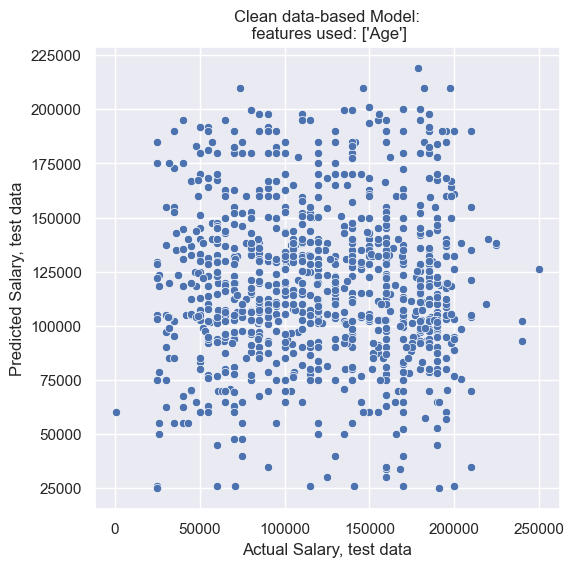



per train data, model's rmsle based on ['Age', 'Years of Experience'] is: 0.40
per test data, model's rmsle based on ['Age', 'Years of Experience'] is: 0.63


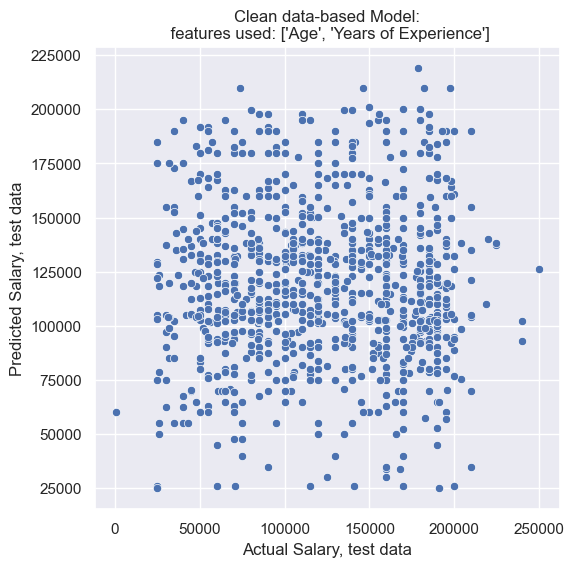



per train data, model's rmsle based on ['Age', 'Years of Experience', 'professionalism'] is: 0.40
per test data, model's rmsle based on ['Age', 'Years of Experience', 'professionalism'] is: 0.63


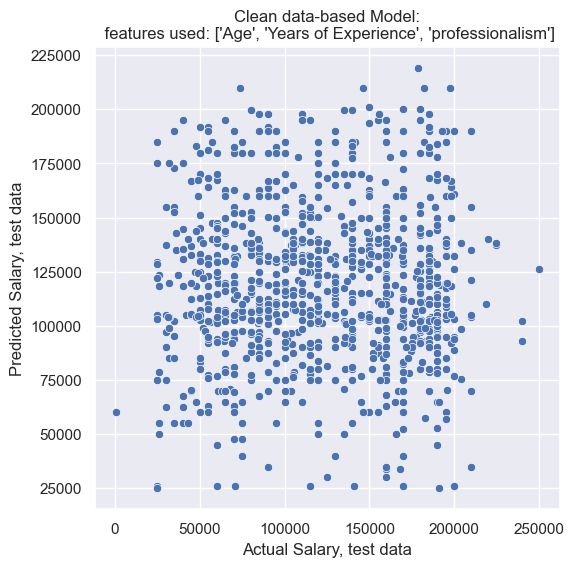



per train data, model's rmsle based on ['Age', 'Years of Experience', 'professionalism', 'height'] is: 0.40
per test data, model's rmsle based on ['Age', 'Years of Experience', 'professionalism', 'height'] is: 0.63


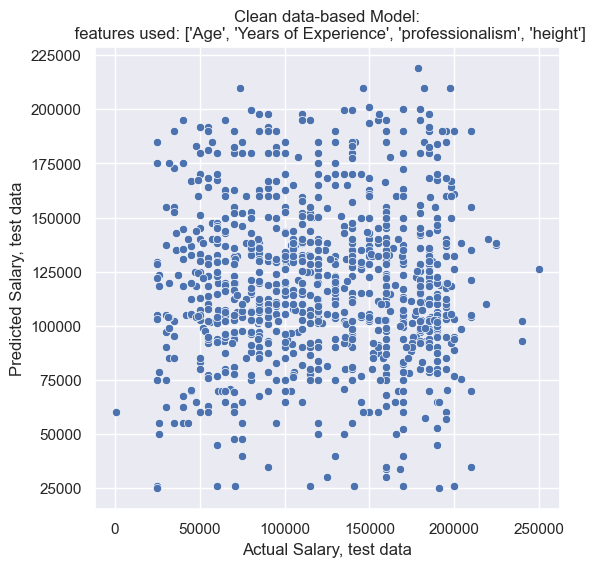



per train data, model's rmsle based on ['Age', 'Years of Experience', 'professionalism', 'height', 'weight'] is: 0.40
per test data, model's rmsle based on ['Age', 'Years of Experience', 'professionalism', 'height', 'weight'] is: 0.63


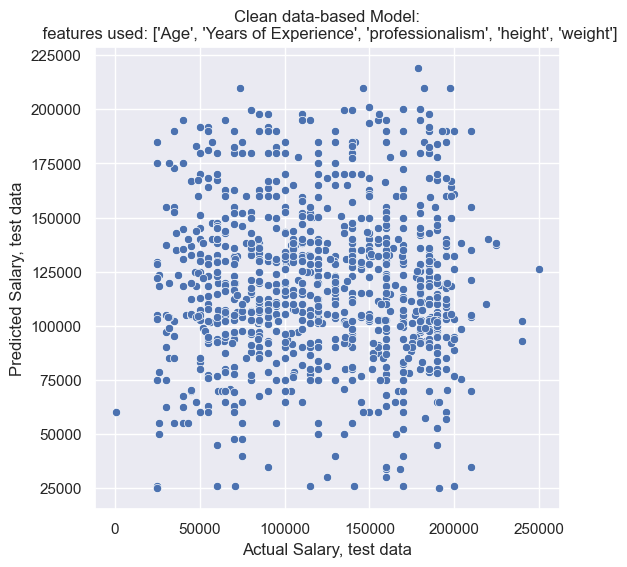



per train data, model's rmsle based on ['Age', 'Years of Experience', 'professionalism', 'height', 'weight', 'group_number'] is: 0.40
per test data, model's rmsle based on ['Age', 'Years of Experience', 'professionalism', 'height', 'weight', 'group_number'] is: 0.63


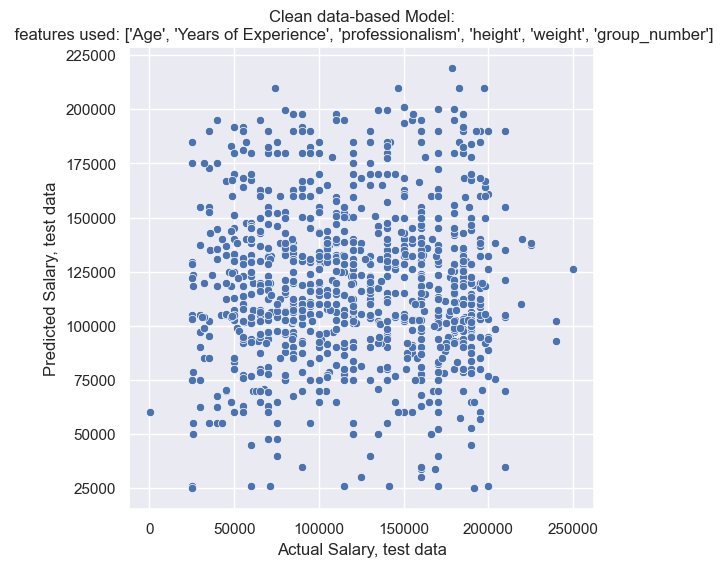

In [1810]:
# custom groupby-based step-wise model, using CLEAN data (data2)

X2 = df_mod2.drop(columns = 'Salary')
y2 = df_mod2.Salary

from sklearn.metrics import mean_squared_error as mse

for i in range(1,len(X_train.columns.values)+1):
    
  # itterate over tested feature combinations
  features = list(X_train.columns[:i].values)
  # features = ['Country_encoded', 'Race_encoded']

  # create an X Series grouped by chosen features; each unique feature combination is group-numbered
  # X_train['group_number'] = X_train.groupby(features).ngroup()
 

  # split the datasets to train and test
  X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

  # create a model per selected features using train data
  model2, X_copy = my_fit_transform(X_train,y_train)

  # predict y (price) per X_test and model2
  y_pred_train = my_predict(X_train, model2)  
  y_pred_test = my_predict(X_test, model2)

  # calc & print model's rmsle
  rmsle_train = rmsle(y_train,y_pred_train)
  rmsle_test = rmsle(y_test,y_pred_test)

  print(f"per train data, model's rmsle based on {features} is: {rmsle_train:.2f}")
  print(f"per test data, model's rmsle based on {features} is: {rmsle_test:.2f}")

  # plot
  fig, ax = plt.subplots()
  sns.scatterplot(x = y_test.values, y = y_pred_test.values)
  plt.title(f"Clean data-based Model:\n features used: {features}")
  plt.xlabel('Actual Salary, test data')
  plt.ylabel('Predicted Salary, test data')
  plt.show()
  print('\n')

In [1351]:
# y_pred2_test.values
features = data2.columns[:-1]
# X['new'] = [(str(X[features[i]]) + '_') for i in range(len(features))]

# for i in range(len(features)):
#     X['new'] = [(str(X[features[i]]) + '_')]
#     X['new']

features

Index(['professionalism', 'Gender_encoded', 'Education Level_encoded',
       'Job Title_encoded', 'Country_encoded', 'Race_encoded'],
      dtype='object')

per train data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded'] is: 0.022
per test data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded'] is: 0.026


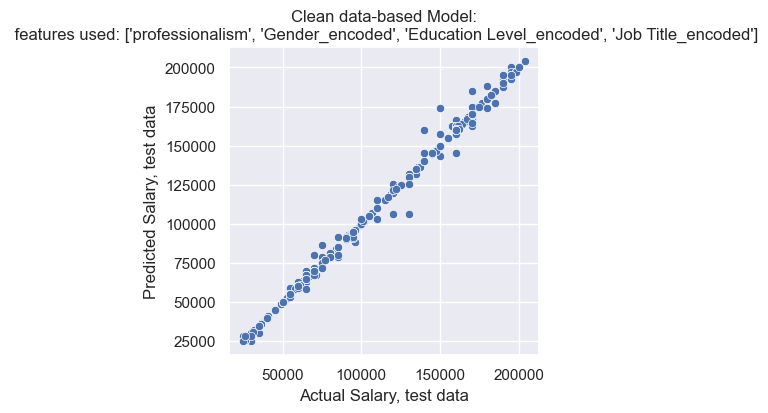

In [1132]:
# testing whether use of all other features (initially neglected) would improve rmsle score

# data3 = data2.join(df_org[['weight']])
# data3 = data2.join(df_org[['Age','Years of Experience','height']])

# recognizing the very high number of nuniques() in 'weight' (and 'height') columns
# data3.groupby(['weight']).ngroup().nunique()

# binning weight
# i = 1
# data3['weight_bins'] = round(data3['weight']/i)*i
# # data3['weight_bins'].nunique()

# # binning height
# i = 0.05
# data3['height_bins'] = round(data3['height']/i)*i
# # data3['height_bins'].nunique()

# custom groupby-based step-wise model, using CLEAN data (data2)

# X2 = data3.drop(columns = ['Salary','height','weight'])

X2 = data2.drop(columns = ['Salary'])
y2 = data2.Salary

from sklearn.metrics import mean_squared_error as mse

# for i in range(1,len(X2.columns.values)+1):
# cancelled the upper iteration and prints only feature combination with 'best' rmsle
for i in range(0,1):
    
  # itterate over tested feature combinations
  # features = list(X2.columns[:i].values)
  features = list(X2.columns[:4].values)
  # features = ['height_bins', 'weight_bins']

  # create an X Series grouped by chosen features; each unique feature combination is group-numbered
  X2['group_number'] = X2.groupby(features).ngroup()

  # split the datasets to train and test
  X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

  # create a model per selected features using train data
  model2 = my_fit(X2_train,y2_train)

  # predict y (price) per X_test and model2
  y_pred2_train = my_predict(X2_train, model2)  
  y_pred2_test = my_predict(X2_test, model2)

  # calc & print model's rmsle
  rmsle2_train = rmsle(y2_train,y_pred2_train)
  rmsle2_test = rmsle(y2_test,y_pred2_test)

  print(f"per train data, model's rmsle based on {features} is: {rmsle2_train:.3f}")
  print(f"per test data, model's rmsle based on {features} is: {rmsle2_test:.3f}")

  # plot
  fig, ax = plt.subplots()
  sns.scatterplot(x = y2_test.values, y = y_pred2_test.values)
  plt.title(f"Clean data-based Model:\n features used: {features}")
  plt.xlabel('Actual Salary, test data')
  plt.ylabel('Predicted Salary, test data')
  plt.show()
  print('\n')

In [1133]:
# print(y2_test.values,'\n')
# print(y_pred2_test.values)

In [1137]:
# Validating that this upper finding is random-state-proof
# report3, result = [], []

In [1140]:
# # Validating that this upper finding is random-state-proof

# # custom groupby-based step-wise model, using CLEAN data (data2)

# X3 = data2.drop(columns = 'Salary')
# y3 = data2.Salary

# for i in range(1,len(X2.columns.values)+1):
    
#   # itterate over tested feature combinations
#   features = list(X2.columns[:i].values)
#   # features = ['Country_encoded', 'Race_encoded']

#   # split the datasets to train and test while ev through different random states
#   X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.33, random_state= np.random.randint(100))

#   # create an X Series grouped by chosen features; each unique feature combination is group-numbered
#   X3['group_number'] = X3.groupby(features).ngroup()

#   # create a model per selected features using train data
#   model3 = my_fit(X3_train,y3_train)

#   # predict y (price) per X_test and model2
#   y_pred3_train = my_predict(X3_train, model3)  
#   y_pred3_test = my_predict(X3_test, model3)

#   # calc & print model's rmsle
#   rmsle3_train = rmsle(y3_train,y_pred3_train)
#   rmsle3_test = rmsle(y3_test,y_pred3_test)

#   # make report
#   report3.append((rmsle2_test.round(3)))
#   # index of minimal value
# result.append(report3.index(min(report3)))
# report3 = []

# print(result)

                 
#   # print(f"per train data, model's rmsle based on {features} is: {rmsle2_train.round(3)}")
#   # print(f"per test data, model's rmsle based on {features} is: {rmsle2_test.round(3)}\n")

In [1799]:
# # My Solution - KNN - with Pre-Clean data (data)

X2 = df_mod2.drop(columns = 'Salary')
y2 = df_mod2.Salary

# split the datasets to train and test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

# n_neighbors = list(range(2,20))

weights = ['uniform','distance']

leafs = [10, 20, 30, 40, 50]

for weight in weights:
  for leaf in leafs:
    # instantiate class object
    # print(val)
    # print(type(val))
    knr = KNeighborsRegressor(n_neighbors = 5, weights = weight, algorithm = 'ball_tree', leaf_size = leaf)
    
    # fit
    knr.fit(X2_train,y2_train)
    
    # predict
    y_pred_knn_train = knr.predict(X2_train)
    y_pred_knn_test = knr.predict(X2_test)
    
    # score
    # knr_rmse_train = np.sqrt(mean_squared_error(y2_train, y_pred_knn_train))
    # knr_rmse_test = np.sqrt(mean_squared_error(y2_test, y_pred_knn_test))
    knr_rmsle_train = rmsle(y2_train, y_pred_knn_train)
    knr_rmsle_test = rmsle(y2_test, y_pred_knn_test)
    

    # print coeffiecients
    print(f"When weight equals {weight}:")
    print(f"K-Nearest Neighbour Reg. train model's rmse is {knr_rmsle_train:.2f}")
    print(f"K-Nearest Neighbour Reg. test model's rmse is {knr_rmsle_test:.2f}")
    print(f"rmsle_test - rmsle_train = {(knr_rmsle_test - knr_rmsle_train):.4f}\n")

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.51
K-Nearest Neighbour Reg. test model's rmse is 0.57
rmsle_test - rmsle_train = 0.0674

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.51
K-Nearest Neighbour Reg. test model's rmse is 0.57
rmsle_test - rmsle_train = 0.0675

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.51
K-Nearest Neighbour Reg. test model's rmse is 0.57
rmsle_test - rmsle_train = 0.0674

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.51
K-Nearest Neighbour Reg. test model's rmse is 0.57
rmsle_test - rmsle_train = 0.0674

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.51
K-Nearest Neighbour Reg. test model's rmse is 0.57
rmsle_test - rmsle_train = 0.0673

When weight equals distance:
K-Nearest Neighbour Reg. train model's rmse is 0.00
K-Nearest Neighbour Reg. test model's rmse is 0.58
rmsle_test - rmsle_train = 0.5786

Whe

In [1800]:
# # My Solution - KNN - Now with Clean data2
# removing sparse Salary data

df_mod2 = df_mod2[df_mod2['Salary'] < 210000]
df_mod2 = df_mod2[df_mod2['Salary'] > 10000]

# removing sparse 'Professionalism' values
df_mod2 = df_mod2[df_mod2['professionalism'] < 1000]

X2 = df_mod2.drop(columns = 'Salary')
y2 = df_mod2.Salary

# split the datasets to train and test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

# n_neighbors = list(range(2,20))

weights = ['uniform','distance']

leafs = [10, 20, 30, 40, 50]

for weight in weights:
  for leaf in leafs:
    # instantiate class object
    # print(val)
    # print(type(val))
    knr = KNeighborsRegressor(n_neighbors = 5, weights = weight, algorithm = 'ball_tree', leaf_size = leaf)
    
    # fit
    knr.fit(X2_train,y2_train)
    
    # predict
    y_pred_knn_train = knr.predict(X2_train)
    y_pred_knn_test = knr.predict(X2_test)
    
    # score
    # knr_rmse_train = np.sqrt(mean_squared_error(y2_train, y_pred_knn_train))
    # knr_rmse_test = np.sqrt(mean_squared_error(y2_test, y_pred_knn_test))
    knr_rmsle_train = rmsle(y2_train, y_pred_knn_train)
    knr_rmsle_test = rmsle(y2_test, y_pred_knn_test)
    

    # print coeffiecients
    print(f"When weight equals {weight}:")
    print(f"K-Nearest Neighbour Reg. train model's rmsle is {knr_rmsle_train:.2f}")
    print(f"K-Nearest Neighbour Reg. test model's rmsle is {knr_rmsle_test:.2f}")
    print(f"rmsle_test - rmsle_train = {(knr_rmsle_test - knr_rmsle_train):.4f}\n")

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmsle is 0.48
K-Nearest Neighbour Reg. test model's rmsle is 0.56
rmsle_test - rmsle_train = 0.0790

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmsle is 0.48
K-Nearest Neighbour Reg. test model's rmsle is 0.56
rmsle_test - rmsle_train = 0.0790

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmsle is 0.48
K-Nearest Neighbour Reg. test model's rmsle is 0.56
rmsle_test - rmsle_train = 0.0790

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmsle is 0.48
K-Nearest Neighbour Reg. test model's rmsle is 0.56
rmsle_test - rmsle_train = 0.0790

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmsle is 0.48
K-Nearest Neighbour Reg. test model's rmsle is 0.56
rmsle_test - rmsle_train = 0.0790

When weight equals distance:
K-Nearest Neighbour Reg. train model's rmsle is 0.00
K-Nearest Neighbour Reg. test model's rmsle is 0.57
rmsle_test - rmsle_train =

In [1801]:
# Decision Tree Regressor - My Solution with Clean data (data2)

X2 = df_mod2.drop(columns = 'Salary')
y2 = df_mod2.Salary

# split the datasets to train and test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

min_samples_split = list(range(45,100+1,5))

for val in min_samples_split:
  # instantiate class object
  dtr = DecisionTreeRegressor(min_samples_split = val)

  # fit
  dtr.fit(X2_train, y2_train)

  # predict
  y_pred_train_dtr = dtr.predict(X2_train)
  y_pred_test_dtr = dtr.predict(X2_test)


  # score
  dtr_train_rmsle = rmsle(y2_train, y_pred_train_dtr)
  dtr_test_rmsle = rmsle(y2_test, y_pred_test_dtr)
    
  # print scoring stats
  print(f"When minimal samples split equals {val}:")
  print(f"Decision Tree reg. training model's rmsle is {dtr_train_rmsle:.4f}")
  print(f"Decision Tree reg. test model's rmsle is {dtr_test_rmsle:.4f}")
  print(f"the difference between train's and test's rmsle's is {dtr_test_rmsle - dtr_train_rmsle:.4f}\n")  

When minimal samples split equals 45:
Decision Tree reg. training model's rmsle is 0.4859
Decision Tree reg. test model's rmsle is 0.5762
the difference between train's and test's rmsle's is 0.0904

When minimal samples split equals 50:
Decision Tree reg. training model's rmsle is 0.4938
Decision Tree reg. test model's rmsle is 0.5676
the difference between train's and test's rmsle's is 0.0738

When minimal samples split equals 55:
Decision Tree reg. training model's rmsle is 0.4978
Decision Tree reg. test model's rmsle is 0.5654
the difference between train's and test's rmsle's is 0.0676

When minimal samples split equals 60:
Decision Tree reg. training model's rmsle is 0.5004
Decision Tree reg. test model's rmsle is 0.5629
the difference between train's and test's rmsle's is 0.0625

When minimal samples split equals 65:
Decision Tree reg. training model's rmsle is 0.5042
Decision Tree reg. test model's rmsle is 0.5583
the difference between train's and test's rmsle's is 0.0541

When 

In [1802]:
# Lasso/ridge Linear regression - With Clean data (data2) 
# Nothing to write home about ###########################

X2 = df_mod2.drop(columns = 'Salary')
y2 = df_mod2.Salary

# split the datasets to train and test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

# define alphas to interate through
# alphas = [0.000001, 0.01, 0.1,1, 10,100, 1000,10000]
alphas = [0.000001, 0.01, 0.1,1, 10,100, 10000, 100000, 1000000, 10000000]

from sklearn.linear_model import LinearRegression, Lasso, Ridge

for alpha in alphas:
  # print(alpha)
  # instantiate class object
  lasso = Lasso(alpha = alpha)
  ridge = Ridge(alpha = alpha)

  # fit
  lasso.fit(X2_train, y2_train)
  ridge.fit(X2_train, y2_train)

  # predict
  y_pred_lasso_train = lasso.predict(X2_train)
  y_pred_ridge_train = ridge.predict(X2_train)
  y_pred_lasso_test = lasso.predict(X2_test)
  y_pred_ridge_test = ridge.predict(X2_test)

  # score
  lasso_rmsle_train = rmsle(y2_train, y_pred_lasso_train)
  ridge_rmsle_train = rmsle(y2_train, y_pred_ridge_train)
  lasso_rmsle_test = rmsle(y2_test, y_pred_lasso_test)
  ridge_rmsle_test = rmsle(y2_test, y_pred_ridge_test)

  # print coeffiecients
  print(f'for alpha = {alpha}:')
  print(f"lasso rmsle train is {lasso_rmsle_train:.3f} and test rmsle is {lasso_rmsle_test:.3f}")
  print(f"ridge rmsle train is {ridge_rmsle_train:.3f} and test rmsle is {ridge_rmsle_test:.3f}\n")

  # print(f"and features {X_train[['Country_encoded','Race_encoded']].columns.values}:")
  # print(f"lasso coefficients are: {lasso.coef_}")
  # print(f"ridge coefficients are: {ridge.coef_}\n")

for alpha = 1e-06:
lasso rmsle train is 0.544 and test rmsle is 0.527
ridge rmsle train is 0.544 and test rmsle is 0.527

for alpha = 0.01:
lasso rmsle train is 0.544 and test rmsle is 0.527
ridge rmsle train is 0.544 and test rmsle is 0.527

for alpha = 0.1:
lasso rmsle train is 0.544 and test rmsle is 0.527
ridge rmsle train is 0.544 and test rmsle is 0.527

for alpha = 1:
lasso rmsle train is 0.544 and test rmsle is 0.527
ridge rmsle train is 0.544 and test rmsle is 0.527

for alpha = 10:
lasso rmsle train is 0.544 and test rmsle is 0.527
ridge rmsle train is 0.544 and test rmsle is 0.527

for alpha = 100:
lasso rmsle train is 0.544 and test rmsle is 0.527
ridge rmsle train is 0.544 and test rmsle is 0.527

for alpha = 10000:
lasso rmsle train is 0.545 and test rmsle is 0.527
ridge rmsle train is 0.545 and test rmsle is 0.527

for alpha = 100000:
lasso rmsle train is 0.545 and test rmsle is 0.527
ridge rmsle train is 0.545 and test rmsle is 0.527

for alpha = 1000000:
lasso rmsle tr

In [1803]:
df_mod2.describe()

,Age,Years of Experience,professionalism,height,weight,Gender_encoded,Job Title_encoded,Country_encoded,Race_encoded,Education_Level_corrected_encoded,Salary
count,4059.00000,4059.000000,4059.000000,4059.000000,4059.000000,4059.000000,4059.000000,4059.000000,4059.000000,4059.000000,4059.000000
mean,34.57625,9.061345,284.263119,2.005666,65.284799,0.550382,82.897758,2.001971,4.904656,1.209165,117312.250801
std,7.00660,5.283993,249.388648,0.295251,17.312445,0.497516,49.920589,1.413864,3.390406,1.212858,50915.851310
min,22.00000,1.000000,0.000000,1.500000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25000.000000
25%,29.00000,5.000000,84.000000,1.800000,53.000000,0.000000,38.000000,1.000000,1.000000,0.000000,72000.000000
50%,33.00000,8.000000,204.000000,2.000000,63.000000,1.000000,87.000000,2.000000,5.000000,1.000000,119000.000000
75%,38.00000,13.000000,418.000000,2.300000,76.000000,1.000000,139.000000,3.000000,9.000000,2.000000,160000.000000
max,60.00000,24.000000,990.000000,2.500000,139.000000,1.000000,164.000000,4.000000,9.000000,3.000000,204000.000000
